In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
import torch
from sbi import utils as utils
from sbi.inference.snre.snre_a import SNRE_A

In [159]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), high=2*torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1


In [164]:
thetas = prior.sample((10000,))
x = ([simulator(theta).numpy() for theta in thetas])
x = torch.Tensor(x)

In [171]:
# instantiate the neural density estimator
neural_classifier = utils.classifier_nn(model='resnet')

snre = SNRE_A(prior, classifier=neural_classifier, show_progress_bars=True)

In [169]:
snre.append_simulations(thetas, x)

In [170]:
snre.train(thetas, x)

 Training neural network. Epochs trained:  40Neural network successfully converged after 40 epochs.


Sequential(
  (0): StandardizeInputs(
    (embedding_net_x): Sequential(
      (0): Standardize()
      (1): Identity()
    )
    (embedding_net_y): Sequential(
      (0): Standardize()
      (1): Identity()
    )
  )
  (1): ResidualNet(
    (initial_layer): Linear(in_features=6, out_features=50, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=50, out_features=50, bias=True)
          (1): Linear(in_features=50, out_features=50, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=50, out_features=50, bias=True)
          (1): Linear(in_features=50, out_features=50, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layer): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [121]:
posterior = snre.build_posterior(mcmc_method="nuts")

In [122]:
theta_test = prior.sample((1,))
x_o = simulator(theta_test)

In [123]:
posterior_samples = posterior.sample((200,), x=x_o)

Sample: 100%|██████████| 2021/2021 [00:14, 140.46it/s, step size=4.93e-01, acc. prob=0.441]


In [124]:
import corner

  6%|▌         | 580/10200 [11:13<3:06:09,  1.16s/it]


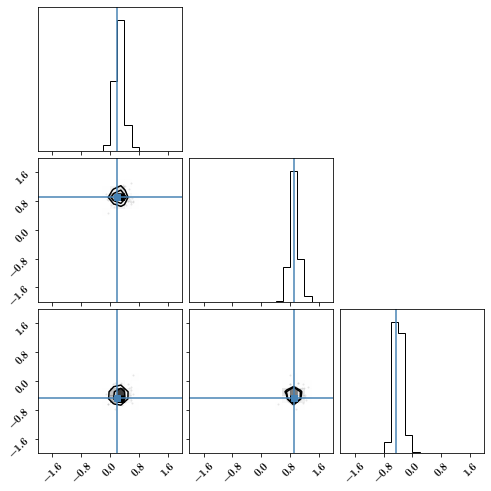

In [125]:
corner.corner(posterior_samples, truths=theta_test[0], range=[[-2,2],[-2,2],[-2,2]],);